In [44]:
import gmsh

In [45]:
def create_model(width, height, p_reactangle, name):
    gmsh.initialize()

    p1 = gmsh.model.geo.addPoint(0, 0, 0, p_reactangle)
    p2 = gmsh.model.geo.addPoint(width, 0, 0, p_reactangle)
    p3 = gmsh.model.geo.addPoint(width, height, 0, p_reactangle)
    p4 = gmsh.model.geo.addPoint(0, height, 0, p_reactangle)

    # Создаем линии прямоугольника
    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p1)

    # Создаем замкнутый контур прямоугольника
    cl = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
    surface = gmsh.model.geo.addPlaneSurface([cl])
    gmsh.model.addPhysicalGroup(2, [surface], 1)
    # gmsh.model.addPhysicalGroup(1, [l1], 2)
    # gmsh.model.addPhysicalGroup(1, [l2], 3)
    # gmsh.model.addPhysicalGroup(1, [l3], 4)
    gmsh.model.addPhysicalGroup(1, [l4, l1, l2, l3], 1)
    gmsh.model.geo.synchronize()
    gmsh.model.mesh.generate(2)
    gmsh.option.setNumber("Mesh.MshFileVersion", 2)
    gmsh.write(name)
    gmsh.finalize()

create_model(1, 1, 0.1, './models/m1.msh')
create_model(1, 1, 0.05, './models/m2.msh')
create_model(1, 1, 0.01, './models/correct.msh')

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000563026s, CPU 0.000938s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00593059s, CPU 0.005538s)
Info    : 142 nodes 286 elements
Info    : Writing './models/m1.msh'...
Info    : Done writing './models/m1.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000560197s, CPU 0.000832s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.022705s, CPU 0.022764s)
Info    : 513 nodes 1028 elements
Info    : Writing './models/m2.msh'...
Info    : Done writing './models/m2.msh'
Info    :

Info    : Done meshing 2D (Wall 0.323248s, CPU 0.323338s)
Info    : 11833 nodes 23668 elements
Info    : Writing './models/correct.msh'...
Info    : Done writing './models/correct.msh'


In [46]:
import pyvista
print(pyvista.global_theme.jupyter_backend)
pyvista.start_xvfb()
pyvista.set_jupyter_backend("trame")

def show(name):
    p = pyvista.Plotter(window_size=(800, 800))
    mesh = pyvista.read(name)
    p.add_mesh(mesh, show_edges=True)
    if not pyvista.OFF_SCREEN:
        p.view_xy()
        p.show(jupyter_backend='ipykernel')

trame


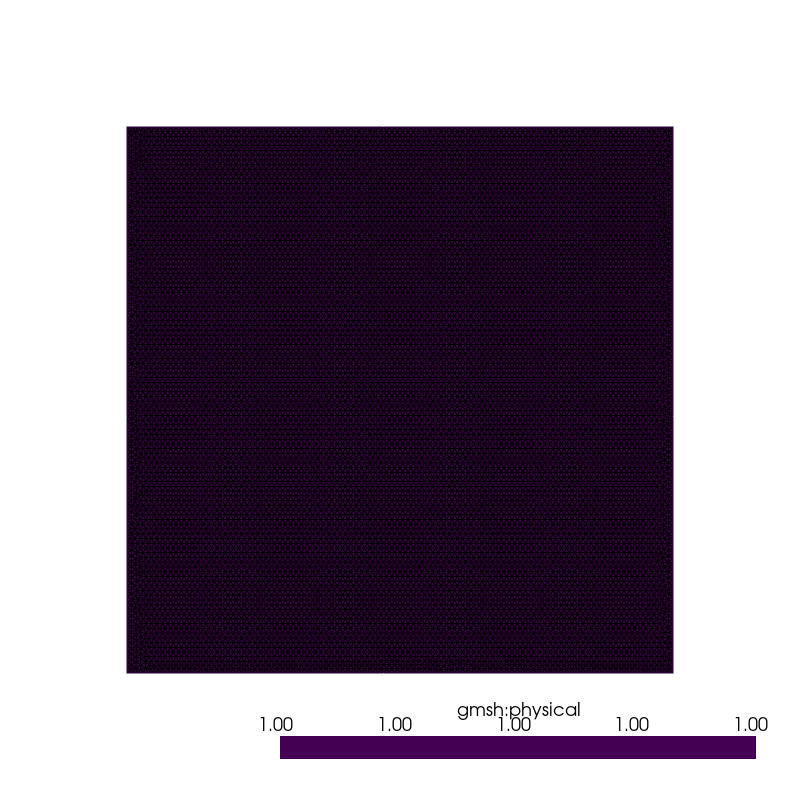

In [47]:
show('./models/correct.msh')

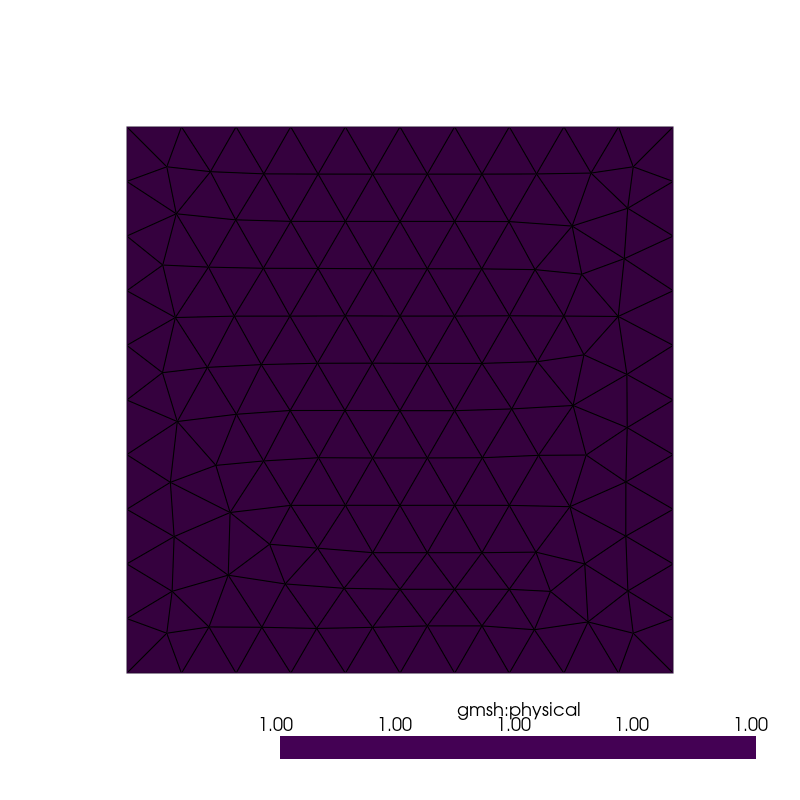

In [48]:
show('./models/m1.msh')

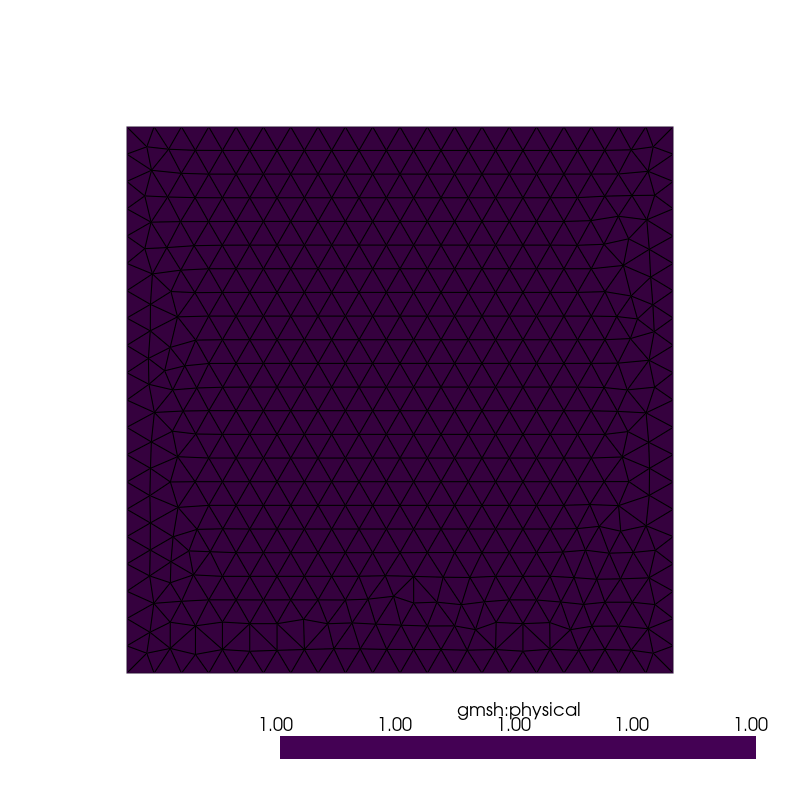

In [49]:
show('./models/m2.msh')

In [50]:
import subprocess

In [51]:
# TODO to meshio
def dolfinConvert(name: str):
    meshfilebasename = f'./models/{name}'
    command = 'dolfin-convert {f}.msh {f}.xml'.format(f=meshfilebasename)
    subprocess.check_call(command.split())

In [52]:
dolfinConvert('m1')
dolfinConvert('m2')
dolfinConvert('correct')

Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified


Expecting 142 vertices
Found all vertices
Expecting 242 cells
Found all cells
Conversion done
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified


Expecting 513 vertices
Found all vertices
Expecting 944 cells
Found all cells
Conversion done
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified


Expecting 11833 vertices
Found all vertices
Expecting 23264 cells
Found all cells
Conversion done


In [82]:
from dolfin import *

In [77]:
class Solver():
    def __init__(self, name: str):
        self.__loadMesh(name)
        self.bcs = []
        self.u = TrialFunction(self.V)
        self.v = TestFunction(self.V)
        
       
        self.T = 1.0
        self.dt = self.T / 10
        self.lamda = Constant(1.0)
        self.C = Constant(1.0)
        self.f = Constant(0.0)

        self.__loadBoundaries()
  

        u0_val = Constant(20)
        self.u0 = interpolate(u0_val, self.V)

        self.__loadVelocity()
    def __loadMesh(self, name: str):
        self.mesh = Mesh(f'{name}.xml')
        self.subdomains = MeshFunction('size_t', self.mesh, f'{name}_physical_region.xml')
        self.boundaries = MeshFunction('size_t', self.mesh, f'{name}_facet_region.xml')
        self.V = FunctionSpace(self.mesh, "CG", 1)
        
        self.dx = Measure('dx', domain = self.mesh, subdomain_data = self.subdomains)
        self.ds = Measure('ds', domain = self.mesh, subdomain_data = self.boundaries)
    def __loadBoundaries(self):
        T1 = Constant(0.0)
        bc_1 = DirichletBC(self.V, T1, self.boundaries, 1)
        self.bcs = [bc_1]
    def __loadVelocity(self):
        self.a = (self.C/self.dt) * self.u * self.v * self.dx + self.lamda * inner(grad(self.u), grad(self.v)) * self.dx
        self.L = (self.C/self.dt) * self.u0 * self.v * self.dx + self.f * self.v * self.dx
    def solve(self):
        solutions = []
        t = 0
        u = Function(self.V)
        while t < self.T + DOLFIN_EPS:
            t += self.dt
            solve(self.a == self.L, u, self.bcs)
            self.u0.assign(u)
            solutions.append(u.copy(deepcopy=True))
        return solutions

In [78]:
solver = Solver('./models/correct')

In [79]:
solutions = solver.solve()

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


In [80]:
uf = File("results/correct.pvd")
for solve in solutions:
    uf << solve

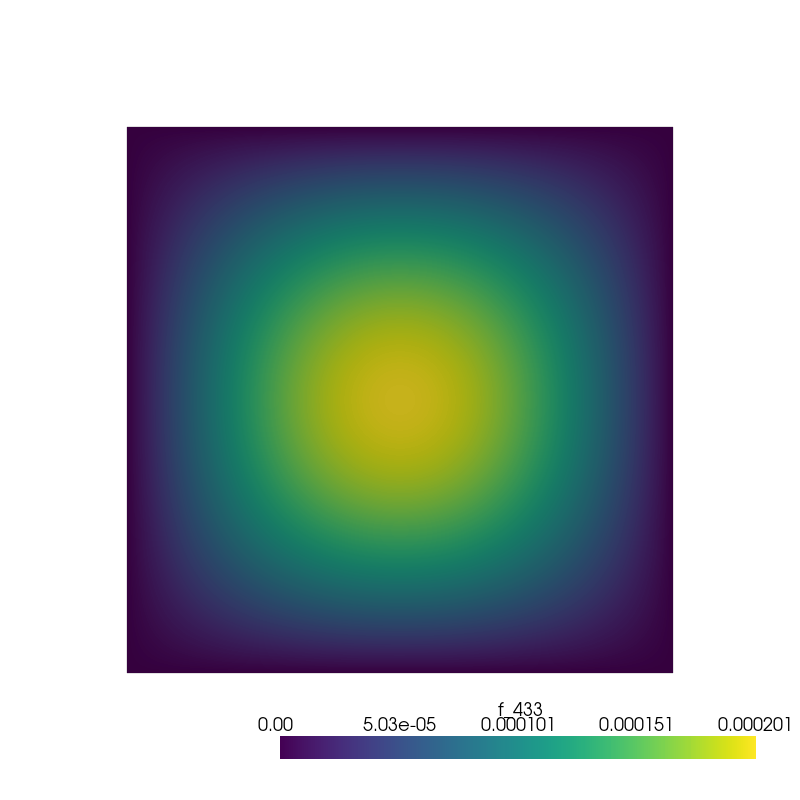

In [58]:
p = pyvista.Plotter(window_size=(800, 800))
mesh = pyvista.read('results/correct.pvd')
p.add_mesh(mesh, scalars='f_433',)
p.view_xy()
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend='ipykernel')

In [83]:
solver1 = Solver('./models/m1')
solutions1 = solver1.solve()
solver2 = Solver('./models/m2')
solutions2 = solver2.solve()

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


In [94]:
errors = []
errors1 = []

In [95]:
for i in range(len(solutions)):
    u_correct = solutions[i]
    u = solutions1[i]
    u_correct_another_V = interpolate(u_correct, solver.V)
    t = inner(u - u_correct_another_V, u - u_correct_another_V)*solver1.dx
    b = inner(u,u)*solver1.dx
    L2 = sqrt(abs(assemble(t))/abs(assemble(b)))*100

    t = inner(grad(u - u_correct_another_V), grad(u - u_correct_another_V))*solver1.dx
    b = inner(grad(u),grad(u))*solver1.dx
    H1 = sqrt(abs(assemble(t))/abs(assemble(b)))*100
    errors.append([L2, H1])

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [96]:
for i in range(len(solutions)):
    u_correct = solutions[i]
    u = solutions2[i]
    u_correct_another_V = interpolate(u_correct, solver.V)
    t = inner(u - u_correct_another_V, u - u_correct_another_V)*solver2.dx
    b = inner(u,u)*solver2.dx
    L2 = sqrt(abs(assemble(t))/abs(assemble(b)))*100

    t = inner(grad(u - u_correct_another_V), grad(u - u_correct_another_V))*solver2.dx
    b = inner(grad(u),grad(u))*solver2.dx
    H1 = sqrt(abs(assemble(t))/abs(assemble(b)))*100
    errors1.append([L2, H1])

In [98]:
import matplotlib.pyplot as plt

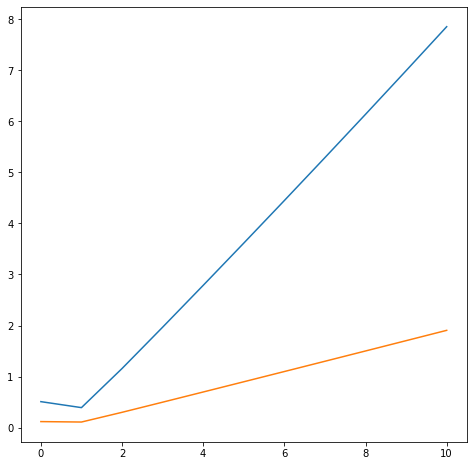

In [99]:
xerr = [i for i in range(len(errors))]
yerr = [r[0] for r in errors]
yerr1 = [r[0] for r in errors1]
plt.figure(figsize=(8, 8))
plt.plot(xerr, yerr)
plt.plot(xerr, yerr1)
plt.show()

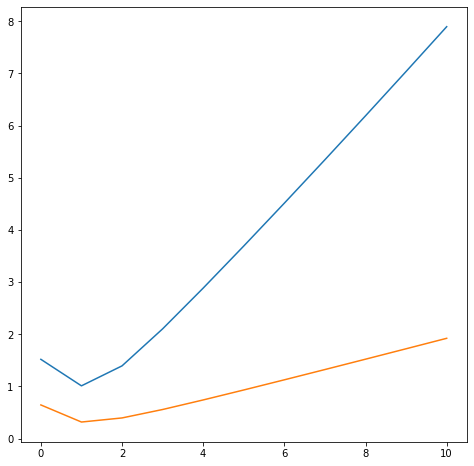

In [100]:
xerr = [i for i in range(len(errors))]
yerr = [r[1] for r in errors]
yerr1 = [r[1] for r in errors1]
plt.figure(figsize=(8, 8))
plt.plot(xerr, yerr)
plt.plot(xerr, yerr1)
plt.show()